# **Model Setup**
## *Assign hot shot label prior to removing data*

## 1. Import Packages

In [1]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

rng = np.random.default_rng(seed=42) # to improve reproducability, but will not be perfect
az.style.use("arviz-darkgrid")

## 2. Load Data

From the Kaggle dataset, key columns used:
* PLAYER_NAME
* SHOT_RESULT (Made/Missed), FGM (binary)
* GAME_ID, PERIOD, GAME_CLOCK
* TOUCH_TIME, SHOT_DIST, CLOSE_DEF_DIST

In [2]:
df = pd.read_csv("shot_logs.csv")
df.columns = df.columns.str.lower()
df.head()

,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,shot_dist,pts_type,shot_result,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


___

# **Data Cleansing**

## 1. Sort Shots
* sort shots in order
* add a time remaining column

In [3]:
# Sequence shots by:
df = df.sort_values(by=['player_name', 'game_id', 'period', 'game_clock'], ascending=[True, True, True, False])

In [4]:
# Add a time remaining column to calculate time between shots for each player
def compute_time_remaining(period, game_clock):
    minutes, seconds = map(int, game_clock.split(':'))
    seconds_remaining = minutes * 60 + seconds
    if period == 1:
        return 2880 - seconds_remaining  # 4 * 12 * 60
    elif period == 2:
        return 2160 - seconds_remaining
    elif period == 3:
        return 1440 - seconds_remaining
    elif period == 4:
        return 720 - seconds_remaining
    else:
        return None  # skip OT

df['time_remaining'] = df.apply(
    lambda row: compute_time_remaining(row['period'], row['game_clock']), axis=1
)

In [5]:
df_raw = df.copy() # save raw data for later use
df.head()

,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,pts_type,shot_result,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id,time_remaining
115398,21400010,"OCT 29, 2014 - CHI @ NYK",A,W,24,1,1,1:12,14.4,11,...,2,made,"Prigioni, Pablo",203143,0.9,1,2,aaron brooks,201166,2808.0
115399,21400010,"OCT 29, 2014 - CHI @ NYK",A,W,24,2,1,0:45,16.3,0,...,3,made,"Smith, Jason",201160,8.0,1,3,aaron brooks,201166,2835.0
115401,21400010,"OCT 29, 2014 - CHI @ NYK",A,W,24,4,2,8:37,10.9,5,...,2,missed,"Smith, Jason",201160,3.0,0,0,aaron brooks,201166,1643.0
115402,21400010,"OCT 29, 2014 - CHI @ NYK",A,W,24,5,2,7:57,11.5,15,...,2,made,"Larkin, Shane",203499,5.2,1,2,aaron brooks,201166,1683.0
115400,21400010,"OCT 29, 2014 - CHI @ NYK",A,W,24,3,2,10:23,18.1,5,...,2,made,"Acy, Quincy",203112,2.3,1,2,aaron brooks,201166,1537.0


## 2. Outliers
* Investigate and understand extreme values
* Remove necessary records to ensure data consistency and prevent unwanted bias
* Thresholds were determined through domain knowledge and modified z-score analysis

### *Function to Remove Extreme Values*
* inputs include column to assess, threshold, and remove upper/lower booleans

In [6]:
# function to inspect column distributions and remove outliers

from scipy.stats import median_abs_deviation

def filter_modified_zscore(df, column, z_thresh=2.0, remove_upper=True, remove_lower=True,plot=True):
    data = df[column]
    
    # modified Z-score
    median = data.median()
    mad = median_abs_deviation(data, scale='normal')
    modified_z = 0.6745 * (data - median) / mad

    if remove_lower and remove_upper:
        mask = (modified_z >= -z_thresh) & (modified_z <= z_thresh)
    elif remove_lower:
        mask = modified_z >= -z_thresh
    elif remove_upper:
        mask = modified_z <= z_thresh
    else:
        mask = np.ones(len(df), dtype=bool)

    df_filtered = df[mask].copy()
    
    num_removed = df.shape[0] - df_filtered.shape[0]
    print(f"Filtered '{column}': Removed {num_removed} rows ({num_removed / df.shape[0] * 100:.2f}%)")

    if plot:
        cutoff_upper = median + (z_thresh / 0.6745) * mad
        cutoff_lower = median - (z_thresh / 0.6745) * mad

        plt.figure(figsize=(10, 6))
        plt.hist(data, bins=50, color='skyblue', edgecolor='black')
        
        if remove_upper:
            plt.axvline(cutoff_upper, color='red', linestyle='--', label=f'Upper Cutoff: {cutoff_upper:.2f}')
        if remove_lower:
            plt.axvline(cutoff_lower, color='green', linestyle='--', label=f'Lower Cutoff: {cutoff_lower:.2f}')
        
        plt.title(f"Distribution of '{column}' with Modified Z-score Cutoffs")
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return df_filtered

### *Closest Defender Distance Outliers*

Filtered 'close_def_dist': Removed 4051 rows (3.16%)


/var/folders/yh/p4fm4m0n3r5bhq8vf5dlnj740000gn/T/ipykernel_80744/4199855362.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


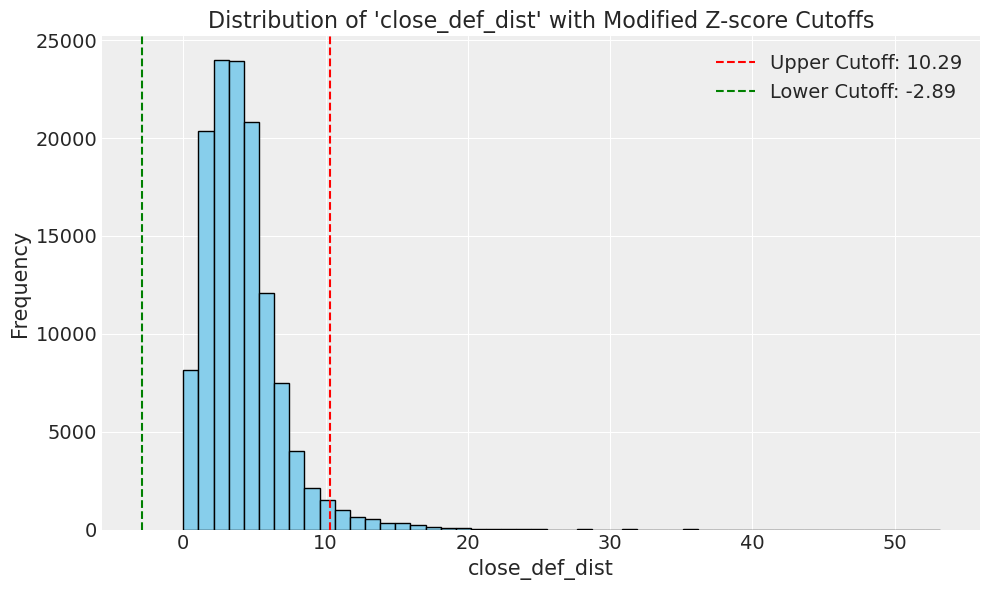

In [7]:
# remove wide open shots
filtered_df_1 = filter_modified_zscore(df, 'close_def_dist', z_thresh=2.0, remove_upper=True, remove_lower=True)

### *Shot Distance Outliers*

Filtered 'shot_dist': Removed 433 rows (0.75%)


/var/folders/yh/p4fm4m0n3r5bhq8vf5dlnj740000gn/T/ipykernel_80744/4199855362.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


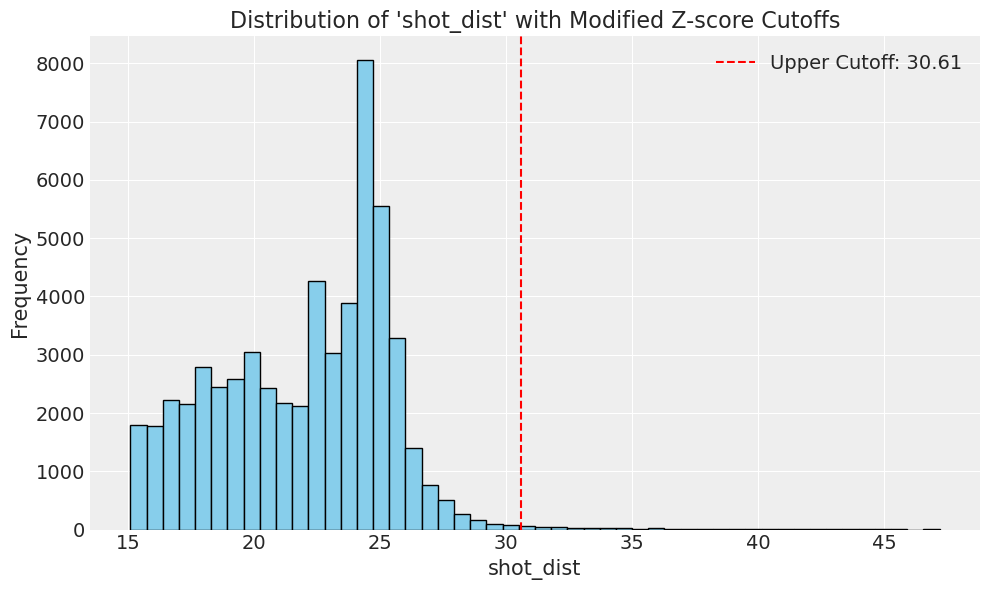

In [8]:
# first, remove close-range shots
filtered_df_2 = filtered_df_1[filtered_df_1['shot_dist'] > 15]

# then, remove long distance shots 
filtered_df_3 = filter_modified_zscore(filtered_df_2, 'shot_dist', z_thresh=1.5, remove_upper=True, remove_lower=False)

### *Shot Clock Outliers*

Filtered 'shot_clock': Removed 1326 rows (2.44%)


/var/folders/yh/p4fm4m0n3r5bhq8vf5dlnj740000gn/T/ipykernel_80744/4199855362.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


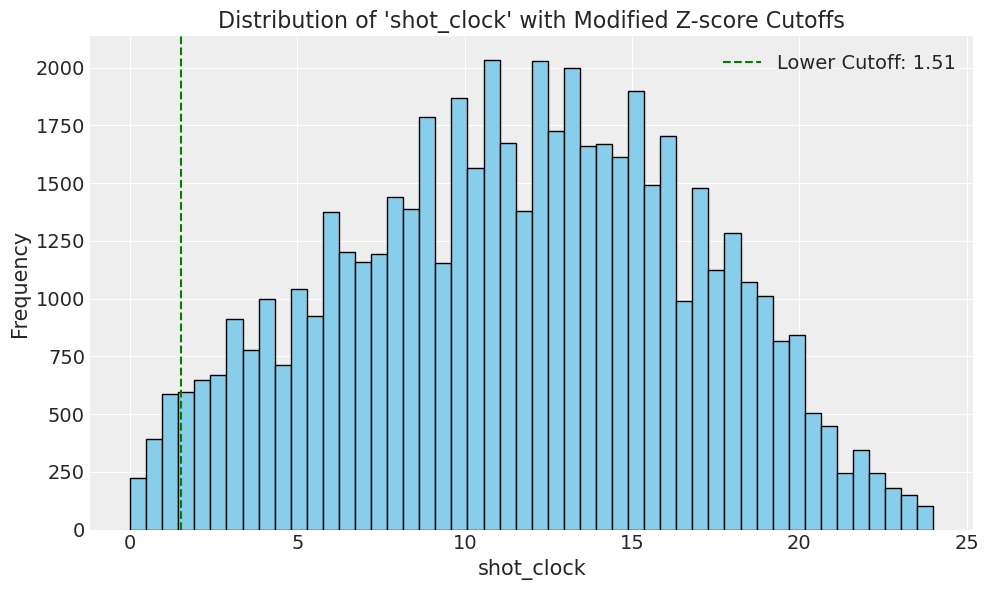

In [9]:
# separate out the NaNs in shot_clock
df_nan_shot_clock = filtered_df_3[filtered_df_3['shot_clock'].isna()].copy()
df_valid_shot_clock = filtered_df_3[filtered_df_3['shot_clock'].notna()].copy()

# modified z-score filter
df_valid_shot_clock = filter_modified_zscore(
    df=df_valid_shot_clock,
    column='shot_clock',
    z_thresh=1.2,
    remove_upper=False,
    remove_lower=True,
    plot=True
)

# add NaNs back
final_filtered_df = pd.concat([df_valid_shot_clock, df_nan_shot_clock], ignore_index=True)

___

# **Hot Shooting Identification**

## 1. Hot Shot Labeling

In [10]:
### function to assign “hot” vs “not hot” label per shot ###

def label_hot_shots_quarter_aware(player_df, n=3, max_gap=45):
    player_df = player_df.sort_values(['game_id', 'period', 'game_clock'], ascending=[True, True, False]).reset_index(drop=True)
    hot_labels = []

    for i in range(len(player_df)):
        if i < n:
            hot_labels.append(False)
            continue

        # get data on the previous 3 shots
        prev_shots = player_df.iloc[i-n:i]
        current_period = player_df.iloc[i]['period']
        current_game = player_df.iloc[i]['game_id']
        current_row = player_df.iloc[i]

        # check time gaps
        prev_times = prev_shots['time_remaining'].values
        time_gaps_ok = all(
            (prev_times[j] - prev_times[j+1] <= max_gap)
            for j in range(n - 1)
        )

        # check if previous 3 were all makes AND in the same period
        if (
            all(prev_shots['fgm'] == 1) and 
            all(prev_shots['period'] == current_period) and
            all(prev_shots['game_id'] == current_game) and
            time_gaps_ok
        ):
            hot_labels.append(True)
        else:
            hot_labels.append(False)

    player_df['hot'] = hot_labels
    return player_df

___

# **Model 1: Building Intuition**
# Assessing "hotness" for a single player
* tests current logic on a single player before applying methods across the league.

## 1. Build PyMC Model

In [11]:
### Apply hot shot labels and then remove outliers ###

# apply hot labels to unfilterd data
df_raw_steph = df_raw.copy()
df_raw_steph = df_raw_steph.reset_index().rename(columns={"index": "shot_id"})
df_unfiltered_steph = df_raw_steph.copy() 
df_unfiltered_steph = df_unfiltered_steph.sort_values(by=['game_id', 'period', 'game_clock'], ascending=[True, True, False])
hot_labels_dict_steph = {}

# grab data for stephen curry
steph_df = df_unfiltered_steph[df_unfiltered_steph["player_name"] == "stephen curry"]

# assign hot shot labels
labeled_steph = label_hot_shots_quarter_aware(steph_df)
num_hot_steph = labeled_steph['hot'].sum()
hot_labels_dict_steph.update(dict(zip(labeled_steph['shot_id'], labeled_steph['hot'])))

# ----------------------------------------------------------- #
### apply filters to remove outliers after labeling hot shots ###

df_filtered_steph = df_unfiltered_steph[df_unfiltered_steph["player_name"] == "stephen curry"].copy()
# defender distance filter
df_filtered_steph = filter_modified_zscore(df_filtered_steph, 'close_def_dist', z_thresh=2.0, remove_upper=True, remove_lower=True, plot=False)
# shot distance filters
df_filtered_steph = df_filtered_steph[df_filtered_steph['shot_dist'] > 15]
df_filtered_steph = filter_modified_zscore(df_filtered_steph, 'shot_dist', z_thresh=1.5, remove_upper=True, remove_lower=False, plot=False)
# shot clock filters
df_nan_shot_clock_steph = df_filtered_steph[df_filtered_steph['shot_clock'].isna()].copy() # separate out the NaNs in shot_clock
df_valid_shot_clock_steph = df_filtered_steph[df_filtered_steph['shot_clock'].notna()].copy() # separate out the non-NaNs in shot_clock
df_valid_shot_clock_steph = filter_modified_zscore(df_valid_shot_clock_steph,'shot_clock',z_thresh=1.2,remove_upper=False,remove_lower=True, plot=False)
final_filtered_df_steph = pd.concat([df_valid_shot_clock_steph, df_nan_shot_clock_steph], ignore_index=True) # add NaNs back

# ----------------------------------------------------------- #
### committing all filters applied above to the main df ###
df_steph = final_filtered_df_steph.copy()

Filtered 'close_def_dist': Removed 38 rows (3.93%)
Filtered 'shot_dist': Removed 8 rows (1.37%)
Filtered 'shot_clock': Removed 50 rows (8.94%)


In [12]:
### model set up ###

labeled_steph = df_steph.copy()
labeled_steph['hot'] = labeled_steph['shot_id'].map(hot_labels_dict_steph)

# Drop rows where 'hot' couldn't be assigned (i.e., rows dropped from outlier filtering)
labeled_steph = labeled_steph[labeled_steph['hot'].notna()]
labeled_steph['hot'] = labeled_steph['hot'].astype(bool)

n_hot_steph = labeled_steph[labeled_steph['hot']]['fgm'].sum() # total number of shots made while hot
n_hot_total_steph = labeled_steph[labeled_steph['hot']].shape[0] # total number of shot attempts while hot
n_not_steph = labeled_steph[~labeled_steph['hot']]['fgm'].sum() # total number of shots made while NOT hot
n_not_total_steph = labeled_steph[~labeled_steph['hot']].shape[0] # total number of shot attempts while NOT hot

In [13]:
with pm.Model() as model1:
    # priors
    theta_hot = pm.Beta("theta_hot", alpha=1, beta=1)
    theta_not = pm.Beta("theta_not", alpha=1, beta=1)

    # likelihoods
    y_hot = pm.Binomial("y_hot", n=n_hot_total_steph, p=theta_hot, observed=n_hot_steph)
    y_not = pm.Binomial("y_not", n=n_not_total_steph, p=theta_not, observed=n_not_steph)

    trace1 = pm.sample(5000, tune=2000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_hot, theta_not]


Output()

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 21 seconds.


## 2. Posterior Analysis

In [14]:
print(f"Hot shots: {n_hot_steph} / {n_hot_total_steph}")
print(f"Not-hot shots: {n_not_steph} / {n_not_total_steph}")

Hot shots: 9 / 20
Not-hot shots: 207 / 507


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_hot,0.453,0.104,0.255,0.64,0.001,0.001,20012.0,14449.0,1.0
theta_not,0.409,0.022,0.367,0.45,0.000,0.000,20204.0,15163.0,1.0


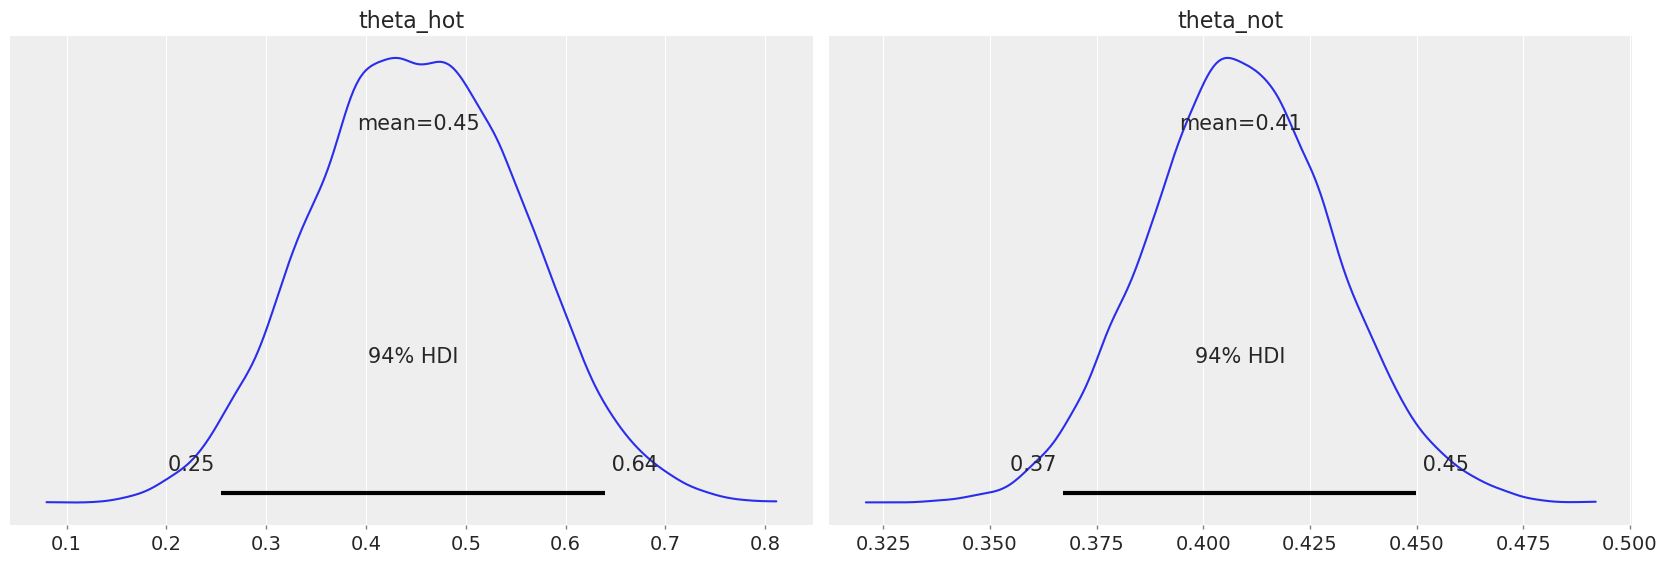

In [15]:
az.plot_posterior(trace1, var_names=["theta_hot", "theta_not"])
az.summary(trace1, var_names=["theta_hot", "theta_not"])

In [16]:
prob_hot_gt_not_steph = (trace1.posterior["theta_hot"] > trace1.posterior["theta_not"]).mean().item()
print(f"P(theta_hot > theta_not): {prob_hot_gt_not_steph:.3f}")

P(theta_hot > theta_not): 0.650


<Axes: title={'center': 'x'}>

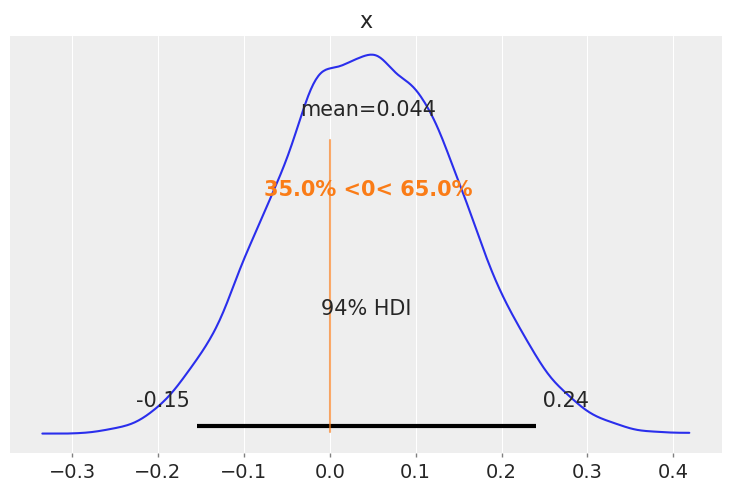

In [17]:
diff = trace1.posterior["theta_hot"] - trace1.posterior["theta_not"]
az.plot_posterior(diff, ref_val=0)

<div style="color:blue">

## 3. Model 1 Commentary (Steph Curry)
* rhat values are 1.0, indicating a good model
* The posterior probability that theta_hot > theta_not is quite low, meaning Steph does not have a hot hand. This probability is so low, it may even give reason to believe that Steph is less likely to make a shot if he has made 3 in a row. 

---

# **Model 2: Apply Single Player Test Case Across League**
# Assessing "hotness" for multiple players

## 1. Build PyMC Model

In [18]:
### Apply hot shot labels and then remove outliers ###

# apply hot labels to unfilterd data
df_raw2 = df_raw.copy()
df_raw2 = df_raw2.reset_index().rename(columns={"index": "shot_id"})
df_unfiltered = df_raw2.copy() 
df_unfiltered = df_unfiltered.sort_values(by=['game_id', 'period', 'game_clock'], ascending=[True, True, False])
hot_labels_dict = {}

for player, group in df_unfiltered.groupby('player_name'):
    labeled = label_hot_shots_quarter_aware(group)
    num_hot = labeled['hot'].sum()

    hot_labels_dict.update(dict(zip(labeled['shot_id'], labeled['hot'])))

# ----------------------------------------------------------- #
### apply filters to remove outliers after labeling hot shots ###

df_filtered = df_unfiltered.copy()
# defender distance filter
df_filtered = filter_modified_zscore(df_filtered, 'close_def_dist', z_thresh=2.0, remove_upper=True, remove_lower=True, plot=False)
# shot distance filters
df_filtered = df_filtered[df_filtered['shot_dist'] > 15]
df_filtered = filter_modified_zscore(df_filtered, 'shot_dist', z_thresh=1.5, remove_upper=True, remove_lower=False, plot=False)
# shot clock filters
df_nan_shot_clock = df_filtered[df_filtered['shot_clock'].isna()].copy() # separate out the NaNs in shot_clock
df_valid_shot_clock = df_filtered[df_filtered['shot_clock'].notna()].copy() # separate out the non-NaNs in shot_clock
df_valid_shot_clock = filter_modified_zscore(df_valid_shot_clock,'shot_clock',z_thresh=1.2,remove_upper=False,remove_lower=True, plot=False)
final_filtered_df = pd.concat([df_valid_shot_clock, df_nan_shot_clock], ignore_index=True) # add NaNs back


# ----------------------------------------------------------- #
### committing all filters applied above to the main df ###
df = final_filtered_df.copy()

Filtered 'close_def_dist': Removed 4051 rows (3.16%)
Filtered 'shot_dist': Removed 433 rows (0.75%)
Filtered 'shot_clock': Removed 1326 rows (2.44%)


In [19]:
### model set up ###

# filter to players with enough total shots
min_shots = 50

# prepare containers
players = []
n_hot = []
n_hot_total = []
n_not = []
n_not_total = []

for player, group in df.groupby('player_name'):
    labeled = group.copy()
    labeled['hot'] = labeled['shot_id'].map(hot_labels_dict)

    # drop rows removed from outlier filtering
    labeled = labeled[labeled['hot'].notna()]
    labeled['hot'] = labeled['hot'].astype(bool)
    
    # skip players with few total shots
    if labeled.shape[0] < min_shots:
        continue

    players.append(player)
    n_hot.append(labeled[labeled['hot']]['fgm'].sum()) # total number of shots made while hot
    n_hot_total.append(labeled[labeled['hot']].shape[0]) # total number of shot attempts while hot
    n_not.append(labeled[~labeled['hot']]['fgm'].sum()) # total number of shots made while NOT hot
    n_not_total.append(labeled[~labeled['hot']].shape[0]) # total number of shot attempts while NOT hot

In [20]:
### PyMC model ###

n_players = len(players)

with pm.Model() as model2:
    # hot shooting
    alpha_hot = pm.HalfNormal("alpha_hot", sigma=10)
    beta_hot = pm.HalfNormal("beta_hot", sigma=10)

    # not-hot shooting
    alpha_not = pm.HalfNormal("alpha_not", sigma=10)
    beta_not = pm.HalfNormal("beta_not", sigma=10)

    # thetas
    theta_hot = pm.Beta("theta_hot", alpha=alpha_hot, beta=beta_hot, shape=n_players)
    theta_not = pm.Beta("theta_not", alpha=alpha_not, beta=beta_not, shape=n_players)

    y_hot = pm.Binomial("y_hot", n=n_hot_total, p=theta_hot, observed=n_hot)
    y_not = pm.Binomial("y_not", n=n_not_total, p=theta_not, observed=n_not)

    trace2 = pm.sample(5000, tune=2000, return_inferencedata=True, target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_hot, beta_hot, alpha_not, beta_not, theta_hot, theta_not]


Output()

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 73 seconds.


## 2. Posterior Analysis

### *Model Results: League Wide Inference*

/opt/anaconda3/envs/pymc_env/lib/python3.13/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (474) in plot_posterior, generating only 40 plots
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_hot[0],0.336,0.088,0.170,0.500,0.001,0.001,22551.0,11298.0,1.0
theta_hot[1],0.335,0.088,0.173,0.500,0.001,0.001,18989.0,12565.0,1.0
theta_hot[2],0.392,0.080,0.242,0.541,0.001,0.001,22273.0,13512.0,1.0
theta_hot[3],0.325,0.081,0.175,0.479,0.001,0.001,22715.0,12320.0,1.0
theta_hot[4],0.358,0.087,0.197,0.523,0.001,0.001,22098.0,12622.0,1.0
...,...,...,...,...,...,...,...,...,...
theta_not[232],0.397,0.020,0.360,0.436,0.000,0.000,28669.0,14297.0,1.0
theta_not[233],0.340,0.022,0.297,0.381,0.000,0.000,27823.0,14868.0,1.0
theta_not[234],0.360,0.029,0.305,0.415,0.000,0.000,28075.0,15334.0,1.0
theta_not[235],0.372,0.030,0.315,0.430,0.000,0.000,28113.0,15067.0,1.0


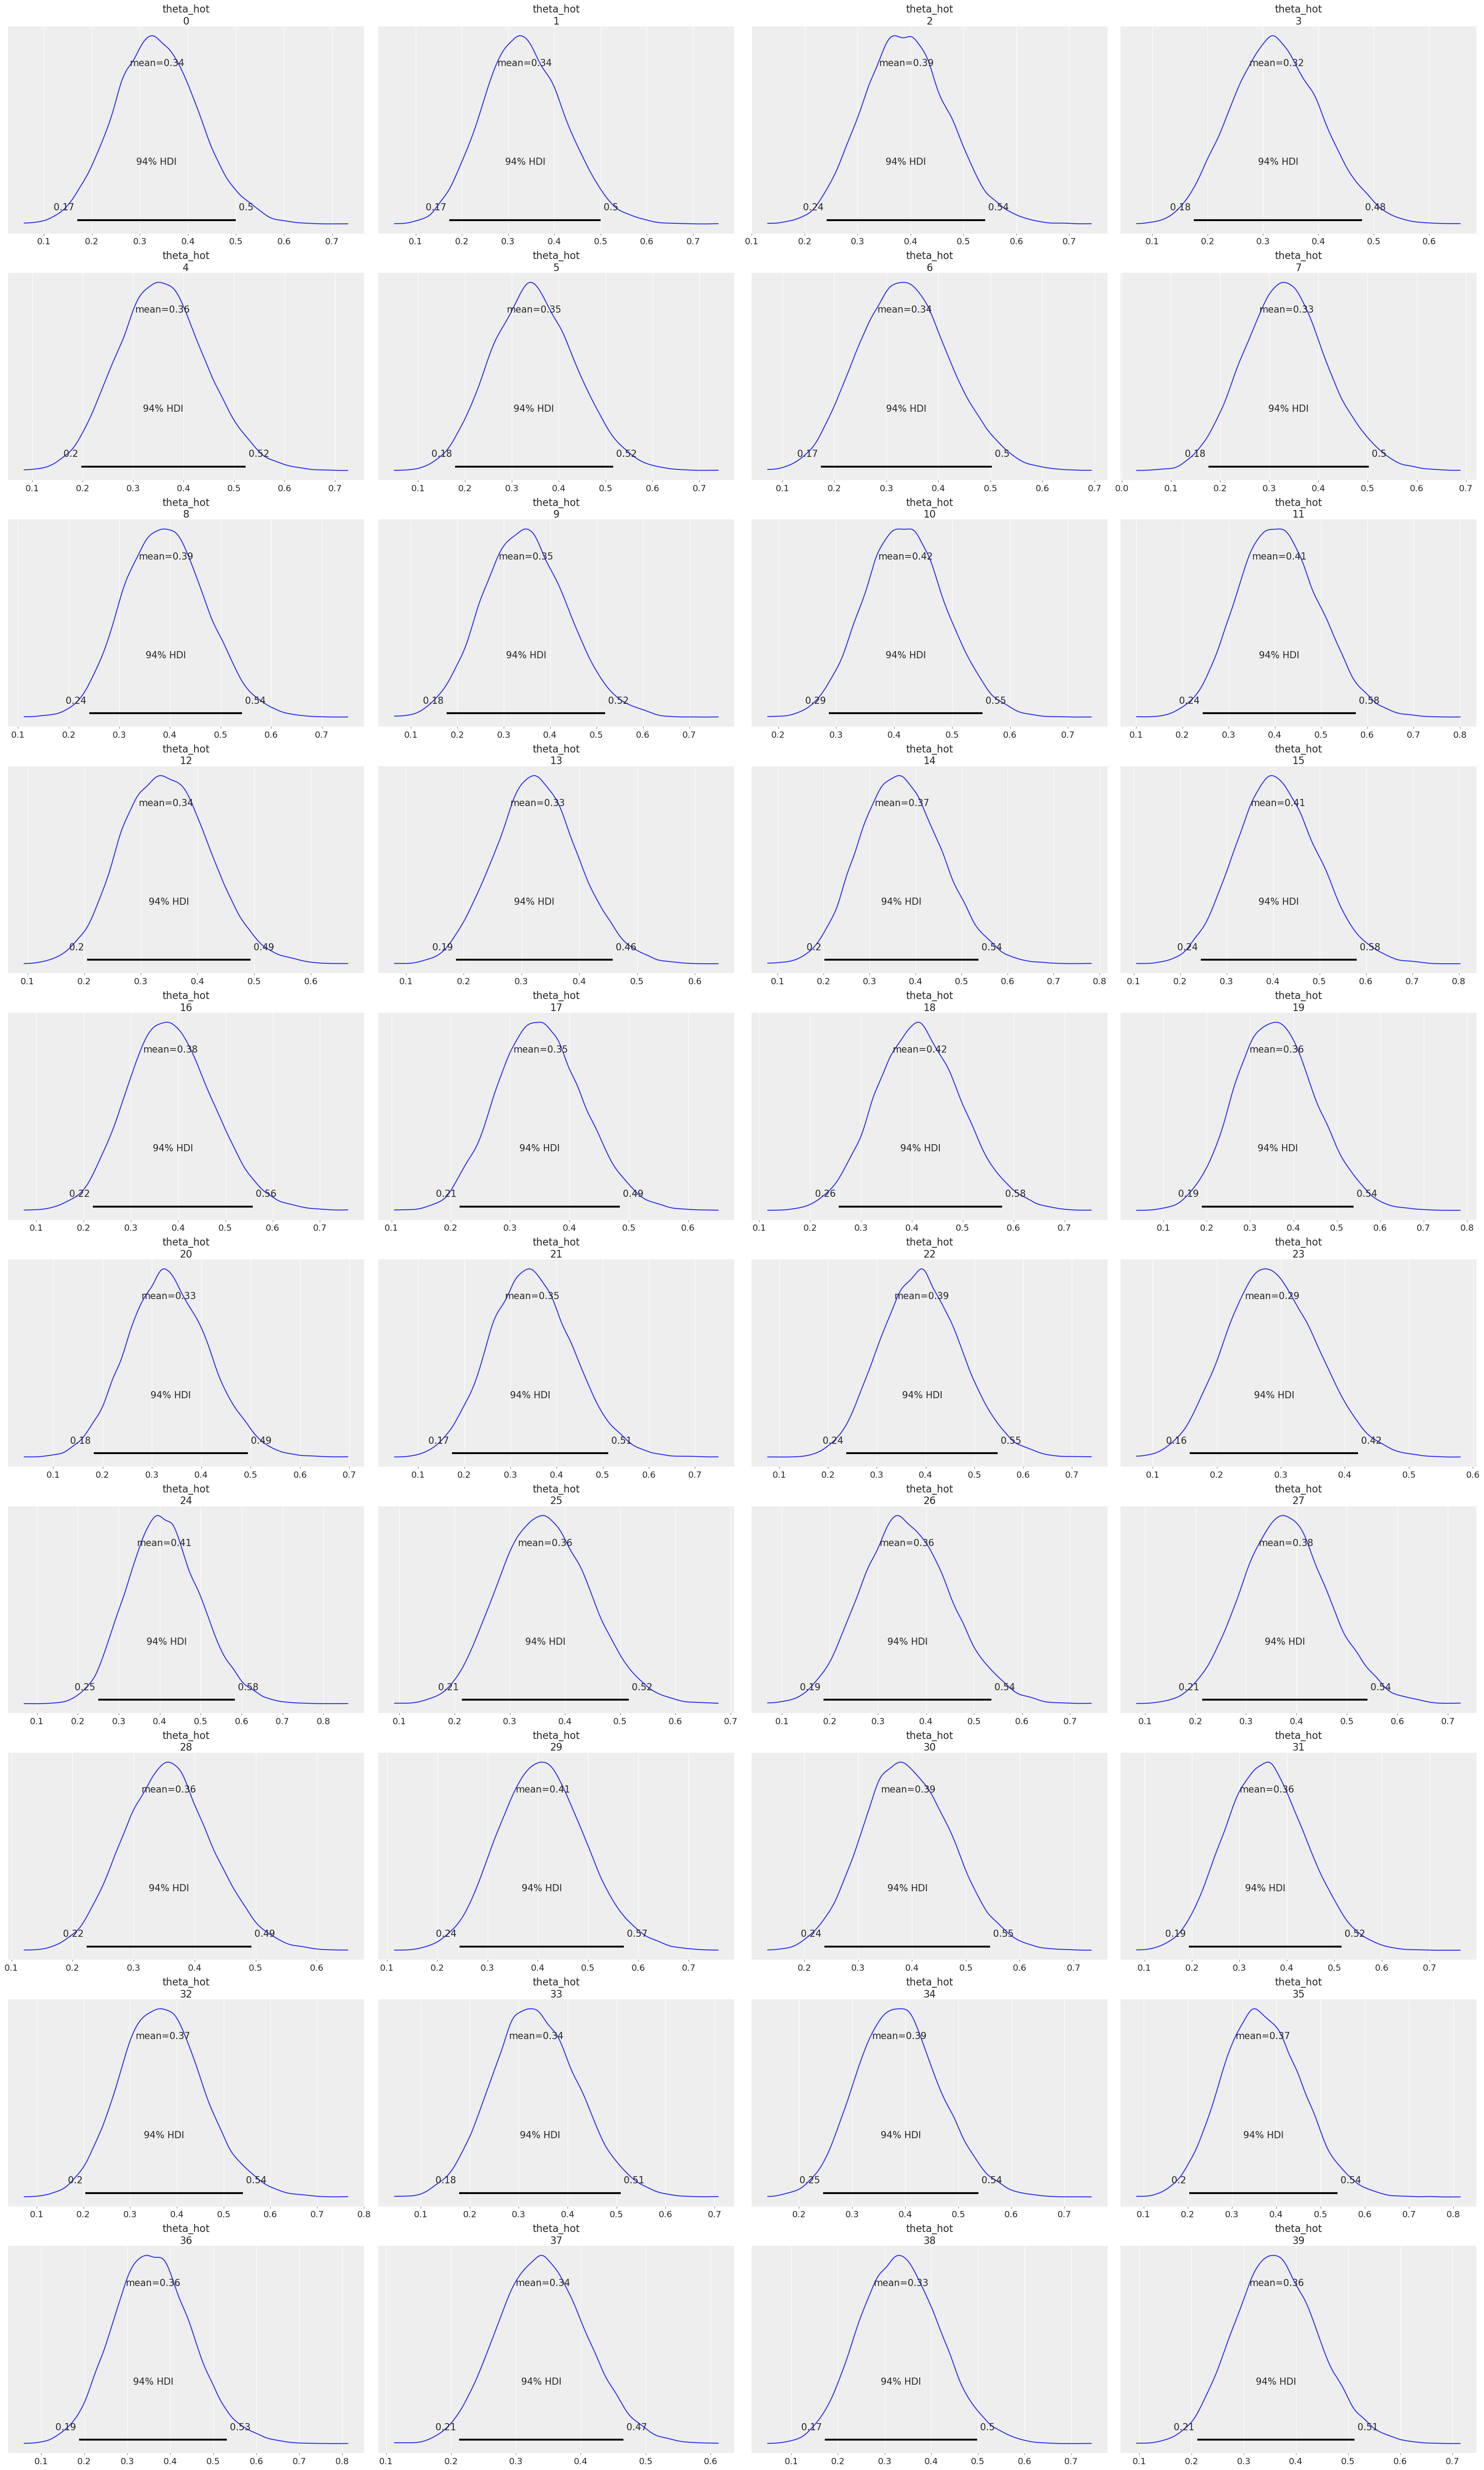

In [21]:
az.plot_posterior(trace2, var_names=["theta_hot", "theta_not"])
az.summary(trace2, var_names=["theta_hot", "theta_not"])

In [22]:
theta_hot_post = trace2.posterior['theta_hot'].stack(draws=("chain", "draw")).values
theta_not_post = trace2.posterior['theta_not'].stack(draws=("chain", "draw")).values

# calculate means
theta_hot_means = theta_hot_post.mean(axis=1)
theta_not_means = theta_not_post.mean(axis=1)
theta_hot_sds = theta_hot_post.std(axis=1)
theta_not_sds = theta_not_post.std(axis=1)

# league-wide averages
leaguewide_theta_hot_mean = theta_hot_means.mean()
leaguewide_theta_not_mean = theta_not_means.mean()
league_sd_hot = theta_hot_sds.mean()
league_sd_not = theta_not_sds.mean()

# save values to dataframe
df_means = pd.DataFrame([{
    "n": 3,
    "t": 45,
    "theta hot (mean)": round(leaguewide_theta_hot_mean, 2),
    "theta not (mean)": round(leaguewide_theta_not_mean, 2),
    "theta hot (sd)": round(league_sd_hot, 2),
    "theta not (sd)": round(league_sd_not, 2),
    "Total hot shots": sum(n_hot_total),
    "Total not-hot shots": sum(n_not_total)
}])

df_means

,n,t,theta hot (mean),theta not (mean),theta hot (sd),theta not (sd),Total hot shots,Total not-hot shots
0,3,45,0.36,0.37,0.09,0.03,1212,53469


### *Model Results: Player-Level Comparison*

In [23]:
### analyzing results to readable format ###

# stack posterior draws into numpy arrays
theta_hot_post = trace2.posterior['theta_hot'].stack(draws=("chain", "draw")).values
theta_not_post = trace2.posterior['theta_not'].stack(draws=("chain", "draw")).values
diffs = theta_hot_post - theta_not_post

# get R-hat values
rhats = az.rhat(trace2)
rhat_hot = rhats['theta_hot'].values
rhat_not = rhats['theta_not'].values
well_converged = (rhat_hot <= 1.01) & (rhat_not <= 1.01)

# compute posterior probability for each player
prob_hot_gt_not_all = (diffs > 0).mean(axis=1)

# combine into intitial summary df
summary_df = pd.DataFrame({
    "player": np.array(players),
    "hot_shots": np.array(n_hot_total),
    "not_hot_shots": np.array(n_not_total),
    "rhat_hot": rhat_hot,
    "rhat_not": rhat_not,
    "converged": well_converged,
    "P(theta_hot > theta_not)": prob_hot_gt_not_all
})

# only show players with well-converged estimates
summary_filtered = summary_df[summary_df["converged"]].copy()
summary_filtered.head(10)

,player,hot_shots,not_hot_shots,rhat_hot,rhat_not,converged,P(theta_hot > theta_not)
0,aaron brooks,2,242,1.000304,1.000044,True,0.26855
1,al farouq aminu,2,99,0.999962,1.000170,True,0.66290
2,al horford,8,274,1.000249,1.000188,True,0.19535
3,al jefferson,6,141,1.000328,1.000135,True,0.18915
4,alan anderson,3,189,1.000767,1.000042,True,0.47865
5,alan crabbe,1,66,1.000006,1.000290,True,0.42750
6,alex len,2,51,1.000035,1.000356,True,0.42495
7,andre iguodala,2,181,1.000043,0.999961,True,0.39395
8,andrew wiggins,8,279,0.999989,1.000155,True,0.65035
9,anthony bennett,1,138,1.000121,1.000191,True,0.48520


In [24]:
# total playres and total players with P > 0.5
total_players = len(summary_filtered)
count_gt_50 = (summary_filtered["P(theta_hot > theta_not)"] > 0.5).sum()
print(f"Total players (filtered for convergence): {total_players}")
print(f"Players with P(theta_hot > theta_not) > 0.5: {count_gt_50} ({round(count_gt_50/total_players*100, 1)}%)")

Total players (filtered for convergence): 237
Players with P(theta_hot > theta_not) > 0.5: 88 (37.1%)


#### *Initial Top 10 Players*

In [25]:
# sort to show top and bottom 10
top10 = summary_filtered.sort_values("P(theta_hot > theta_not)", ascending=False).head(10)

top10_display = top10.copy()
top10_display = top10_display[["player", "hot_shots", "rhat_hot", "rhat_not", "P(theta_hot > theta_not)"]].reset_index(drop=True)
top10_display

,player,hot_shots,rhat_hot,rhat_not,P(theta_hot > theta_not)
0,michael carter-williams,4,1.000239,1.000982,0.86835
1,bojan bogdanovic,6,1.000130,1.000297,0.86400
2,trevor booker,3,1.000108,1.000418,0.86055
3,donald sloan,4,1.000222,1.000707,0.80415
4,james harden,17,0.999925,1.000113,0.80405
5,giannis antetokounmpo,2,1.000548,1.000006,0.77260
6,thaddeus young,3,1.000020,0.999975,0.74605
7,rudy gay,12,1.000169,1.000081,0.74200
8,mario chalmers,3,1.000498,1.000594,0.72400
9,kevin love,12,1.000022,1.000292,0.71800


#### *Revised Top & Bottom 10 Players*

In [26]:
summary_revised = summary_df[
    (summary_df["converged"]) & 
    (summary_df["hot_shots"] >= 5)
].copy()

# total playres and total players with P > 0.5
total_players_revised = len(summary_revised)
count_gt_50_revised = (summary_revised["P(theta_hot > theta_not)"] > 0.5).sum()
print(f"Total players (filtered for convergence & Hot Shot Volume): {total_players_revised}")
print(f"Players with P(theta_hot > theta_not) > 0.5: {count_gt_50_revised} ({round(count_gt_50_revised/total_players_revised*100, 1)}%)")

Total players (filtered for convergence & Hot Shot Volume): 90
Players with P(theta_hot > theta_not) > 0.5: 34 (37.8%)


In [27]:
# grab show top and bottom 10
top10_revised = summary_revised.sort_values("P(theta_hot > theta_not)", ascending=False).head(10)
bottom10_revised = summary_revised.sort_values("P(theta_hot > theta_not)", ascending=True).head(10)

top10_display_revised = top10_revised.copy()
top10_display_revised = top10_display_revised[["player", "hot_shots", "rhat_hot", "rhat_not", "P(theta_hot > theta_not)"]].reset_index(drop=True)
top10_display_revised

,player,hot_shots,rhat_hot,rhat_not,P(theta_hot > theta_not)
0,bojan bogdanovic,6,1.000130,1.000297,0.86400
1,james harden,17,0.999925,1.000113,0.80405
2,rudy gay,12,1.000169,1.000081,0.74200
3,kevin love,12,1.000022,1.000292,0.71800
4,mnta ellis,37,1.000257,1.000597,0.71565
5,trey burke,6,1.001048,1.000020,0.69015
6,nikola vucevic,13,1.000109,1.000301,0.66015
7,jordan hill,10,1.001144,1.000073,0.65830
8,kobe bryant,18,1.000457,1.000368,0.65740
9,andrew wiggins,8,0.999989,1.000155,0.65035


In [28]:
bottom10_display_revised = bottom10_revised.copy()
bottom10_display_revised = bottom10_display_revised[["player", "hot_shots", "rhat_hot", "rhat_not", "P(theta_hot > theta_not)"]].reset_index(drop=True)
bottom10_display_revised

,player,hot_shots,rhat_hot,rhat_not,P(theta_hot > theta_not)
0,jj redick,14,1.000046,1.000285,0.05245
1,russell westbrook,18,1.000213,1.000394,0.06290
2,chris paul,22,1.000475,1.000050,0.06420
3,david west,9,1.000301,0.999964,0.06785
4,dirk nowtizski,6,1.000093,1.000204,0.09655
5,courtney lee,6,1.000147,1.000135,0.10060
6,brandon knight,14,1.000204,1.000337,0.10730
7,marcus morris,6,1.000244,1.000314,0.15030
8,joe johnson,11,1.000203,1.000285,0.15290
9,darren collison,5,1.000123,1.000066,0.15405


## 3. Hyperparameter and Variance Inspection

In [29]:
az.summary(trace2, var_names=["alpha_hot", "beta_hot", "alpha_not", "beta_not"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_hot,10.363,2.839,5.550,15.845,0.070,0.037,1571.0,2764.0,1.0
beta_hot,18.382,4.892,9.861,27.686,0.117,0.059,1673.0,2975.0,1.0
alpha_not,32.402,2.938,26.886,37.913,0.028,0.019,10697.0,12584.0,1.0
beta_not,54.446,4.894,45.094,63.461,0.047,0.031,10728.0,13054.0,1.0


array([<Axes: title={'center': 'alpha_hot'}>,
       <Axes: title={'center': 'beta_hot'}>], dtype=object)

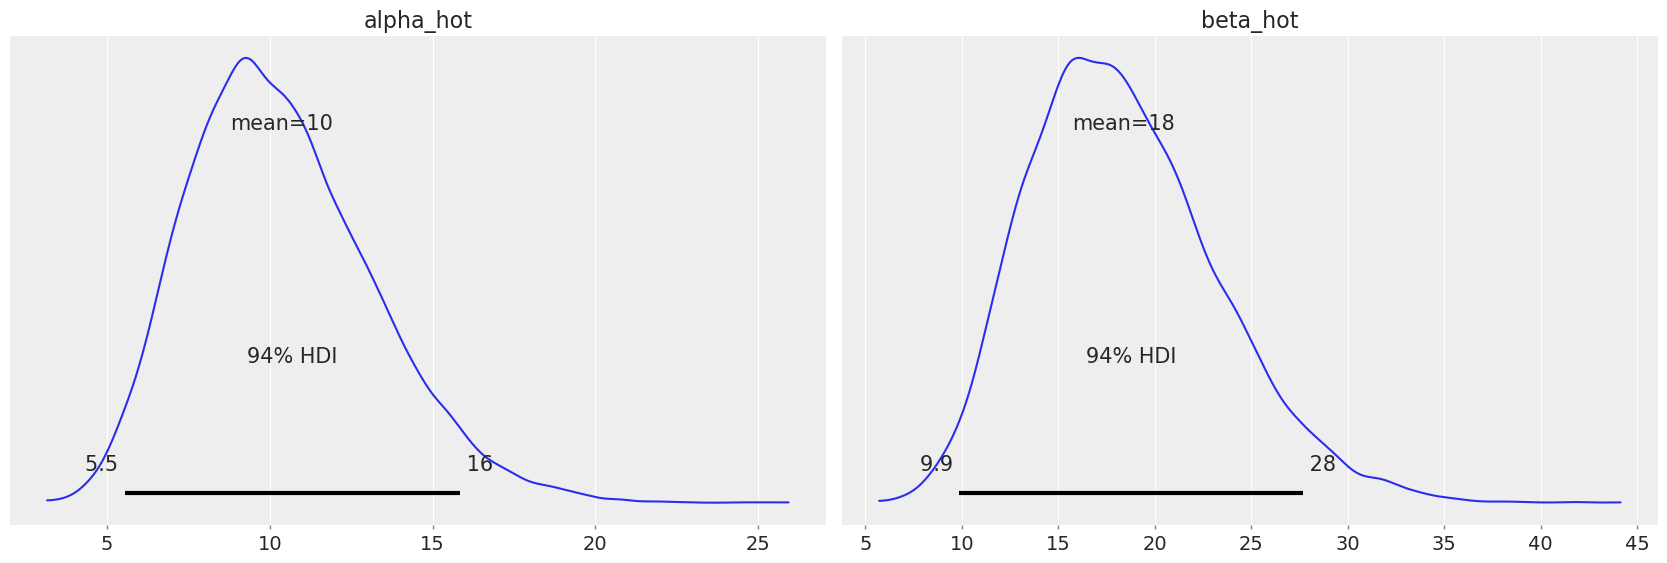

In [30]:
az.plot_posterior(trace2, var_names=["alpha_hot", "beta_hot"])

array([<Axes: title={'center': 'alpha_not'}>,
       <Axes: title={'center': 'beta_not'}>], dtype=object)

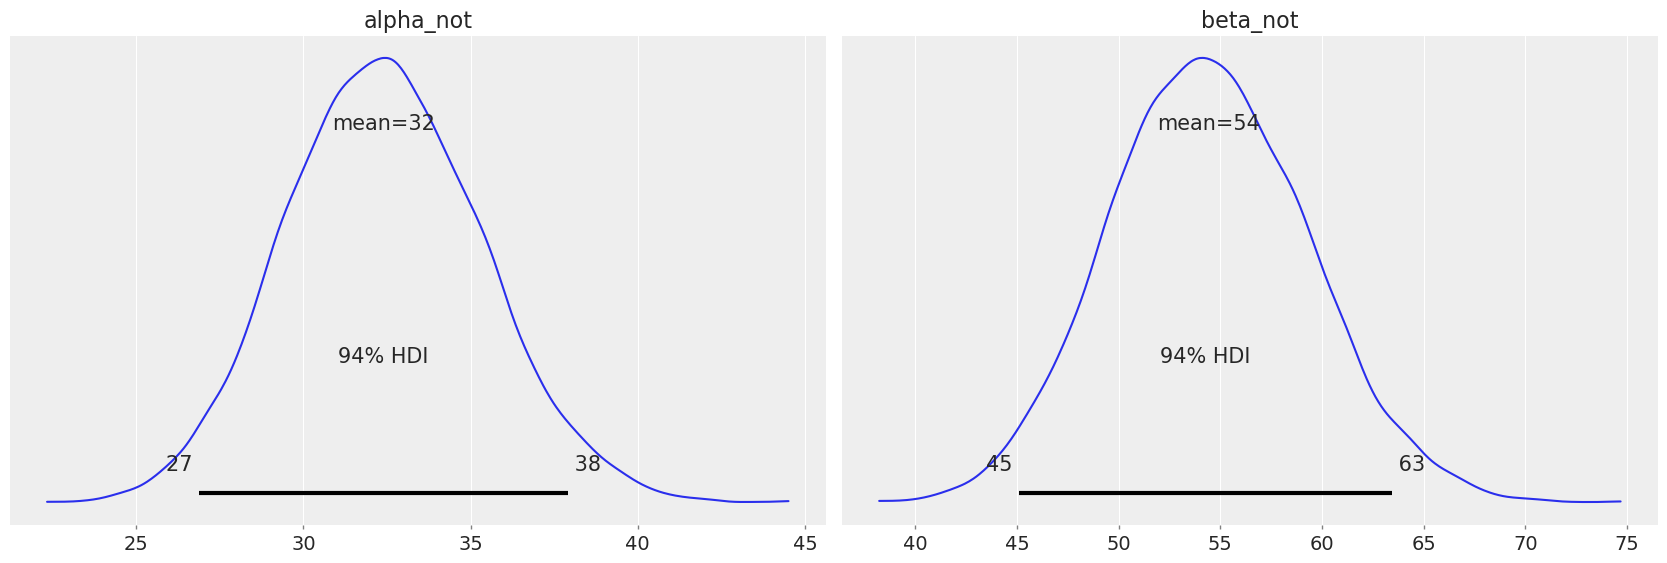

In [31]:
az.plot_posterior(trace2, var_names=["alpha_not", "beta_not"])

<div style="color:blue">

### Model 2 Commentary 
* when players are hot, we see more variation in shot-making ability.
* when players are not-hot, their shot probabilities are more consistent and predictable.
* we also see that the mean success rate when hot is actually slightly lower than when not-hot (when looking across the whole league, i.e., complete pooling).

___

# **Model 3: Sensitivity Analysis**
# Use n = 2 and t = 60 instead of n = 3 and t = 45

## 1. Build PyMC Model

In [32]:
from collections import defaultdict

### Re-assign hot shot labels with n=2 and t=60 ###

# apply hot labels to unfilterd data
df_raw3 = df_raw.copy()
df_raw3 = df_raw3.reset_index().rename(columns={"index": "shot_id"})
df_unfiltered3 = df_raw3.copy() 
df_unfiltered3 = df_unfiltered3.sort_values(by=['game_id', 'period', 'game_clock'], ascending=[True, True, False])
hot_labels_dict3 = {}

for player, group in df_unfiltered3.groupby('player_name'):
    labeled3 = label_hot_shots_quarter_aware(group, n=2, max_gap=60)
    num_hot3 = labeled3['hot'].sum()

    hot_labels_dict3.update(dict(zip(labeled3['shot_id'], labeled3['hot'])))

# ----------------------------------------------------------- #
### re-apply same outlier filters from before ###

df_filtered3 = df_unfiltered3.copy()
# defender distance filter
df_filtered3 = filter_modified_zscore(df_filtered3, 'close_def_dist', z_thresh=2.0, remove_upper=True, remove_lower=True, plot=False)
# shot distance filters
df_filtered3 = df_filtered3[df_filtered3['shot_dist'] > 15]
df_filtered3 = filter_modified_zscore(df_filtered3, 'shot_dist', z_thresh=1.5, remove_upper=True, remove_lower=False, plot=False)
# shot clock filters
df_nan_shot_clock3 = df_filtered3[df_filtered3['shot_clock'].isna()].copy() # separate out the NaNs in shot_clock
df_valid_shot_clock3 = df_filtered3[df_filtered3['shot_clock'].notna()].copy() # separate out the non-NaNs in shot_clock
df_valid_shot_clock3 = filter_modified_zscore(df_valid_shot_clock3,'shot_clock',z_thresh=1.2,remove_upper=False,remove_lower=True, plot=False)
final_filtered_df3 = pd.concat([df_valid_shot_clock3, df_nan_shot_clock3], ignore_index=True) # add NaNs back


# ----------------------------------------------------------- #
### committing all filters applied above to the main df ###
df3 = final_filtered_df3.copy()

Filtered 'close_def_dist': Removed 4051 rows (3.16%)
Filtered 'shot_dist': Removed 433 rows (0.75%)
Filtered 'shot_clock': Removed 1326 rows (2.44%)


In [33]:
### model 3 set up ###

min_shots = 50

players = []
n_hot = []
n_hot_total = []
n_not = []
n_not_total = []

for player, group in df3.groupby('player_name'):
    labeled3 = group.copy()
    labeled3['hot'] = labeled3['shot_id'].map(hot_labels_dict3)

    labeled3 = labeled3[labeled3['hot'].notna()]
    labeled3['hot'] = labeled3['hot'].astype(bool)
    
    if labeled3.shape[0] < min_shots:
        continue

    players.append(player)
    n_hot.append(labeled3[labeled3['hot']]['fgm'].sum()) # total number of shots made while hot
    n_hot_total.append(labeled3[labeled3['hot']].shape[0]) # total number of shot attempts while hot
    n_not.append(labeled3[~labeled3['hot']]['fgm'].sum()) # total number of shots made while NOT hot
    n_not_total.append(labeled3[~labeled3['hot']].shape[0]) # total number of shot attempts while NOT hot

In [34]:
n_players = len(players)

with pm.Model() as model3:
    alpha_hot = pm.HalfNormal("alpha_hot", sigma=10)
    beta_hot = pm.HalfNormal("beta_hot", sigma=10)

    alpha_not = pm.HalfNormal("alpha_not", sigma=10)
    beta_not = pm.HalfNormal("beta_not", sigma=10)

    theta_hot = pm.Beta("theta_hot", alpha=alpha_hot, beta=beta_hot, shape=n_players)
    theta_not = pm.Beta("theta_not", alpha=alpha_not, beta=beta_not, shape=n_players)

    y_hot = pm.Binomial("y_hot", n=n_hot_total, p=theta_hot, observed=n_hot)
    y_not = pm.Binomial("y_not", n=n_not_total, p=theta_not, observed=n_not)

    trace3 = pm.sample(5000, tune=2000, return_inferencedata=True, target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_hot, beta_hot, alpha_not, beta_not, theta_hot, theta_not]


Output()

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 74 seconds.


## 2. Posterior Analysis

### *Model Results: League Wide Inference*

In [35]:
theta_hot_post3 = trace3.posterior['theta_hot'].stack(draws=("chain", "draw")).values
theta_not_post3 = trace3.posterior['theta_not'].stack(draws=("chain", "draw")).values

# calculate means
theta_hot_means3 = theta_hot_post3.mean(axis=1)
theta_not_means3 = theta_not_post3.mean(axis=1)
theta_hot_sds3 = theta_hot_post3.std(axis=1)
theta_not_sds3 = theta_not_post3.std(axis=1)

# league-wide averages
leaguewide_theta_hot_mean3 = theta_hot_means3.mean()
leaguewide_theta_not_mean3 = theta_not_means3.mean()
league_sd_hot3 = theta_hot_sds3.mean()
league_sd_not3 = theta_not_sds3.mean()

# add values to dataframe
new_row = pd.DataFrame([{
    "n": 2,
    "t": 60,
    "theta hot (mean)": round(leaguewide_theta_hot_mean3, 2),
    "theta not (mean)": round(leaguewide_theta_not_mean3, 2),
    "theta hot (sd)": round(league_sd_hot3, 2),
    "theta not (sd)": round(league_sd_not3, 2),
    "Total hot shots": sum(n_hot_total),
    "Total not-hot shots": sum(n_not_total)
}])
df_means = pd.concat([df_means, new_row], ignore_index=True)

df_means

,n,t,theta hot (mean),theta not (mean),theta hot (sd),theta not (sd),Total hot shots,Total not-hot shots
0,3,45,0.36,0.37,0.09,0.03,1212,53469
1,2,60,0.37,0.37,0.06,0.03,4717,49964


## 3. Hyperparameter and Variance Inspection

array([<Axes: title={'center': 'alpha_not'}>,
       <Axes: title={'center': 'beta_not'}>], dtype=object)

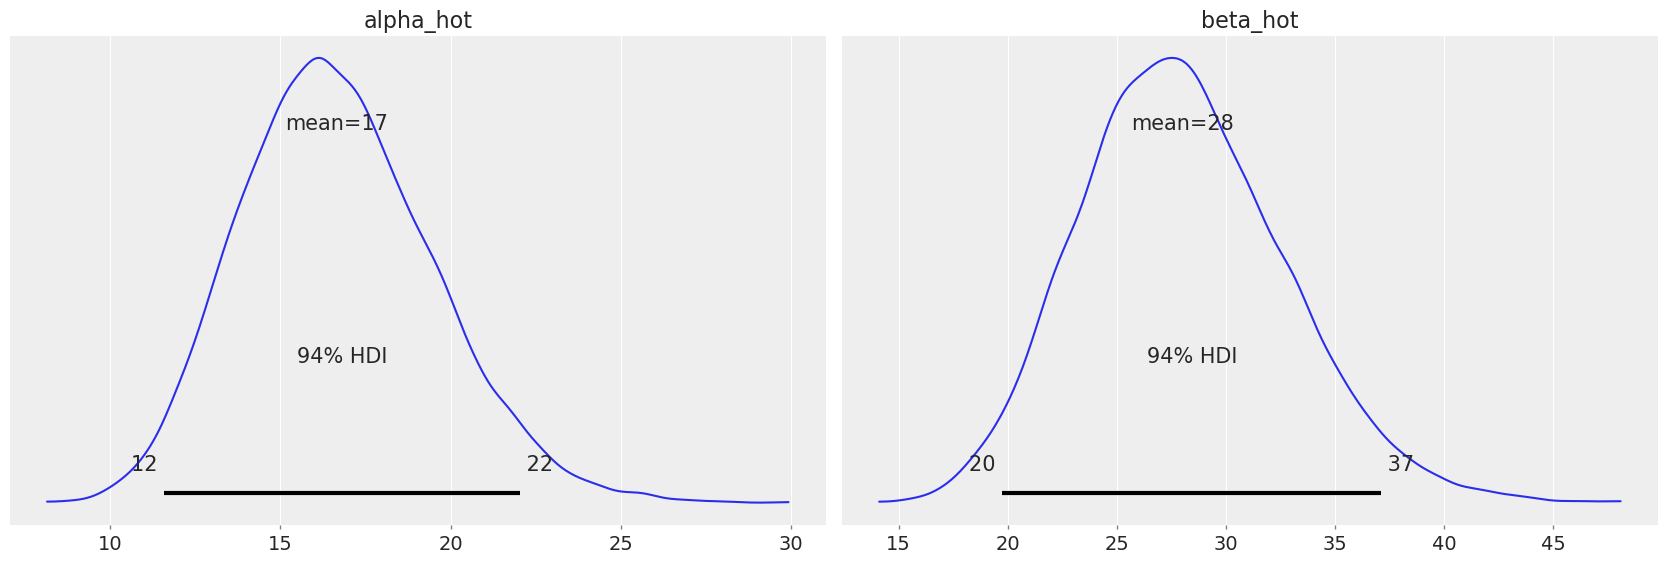

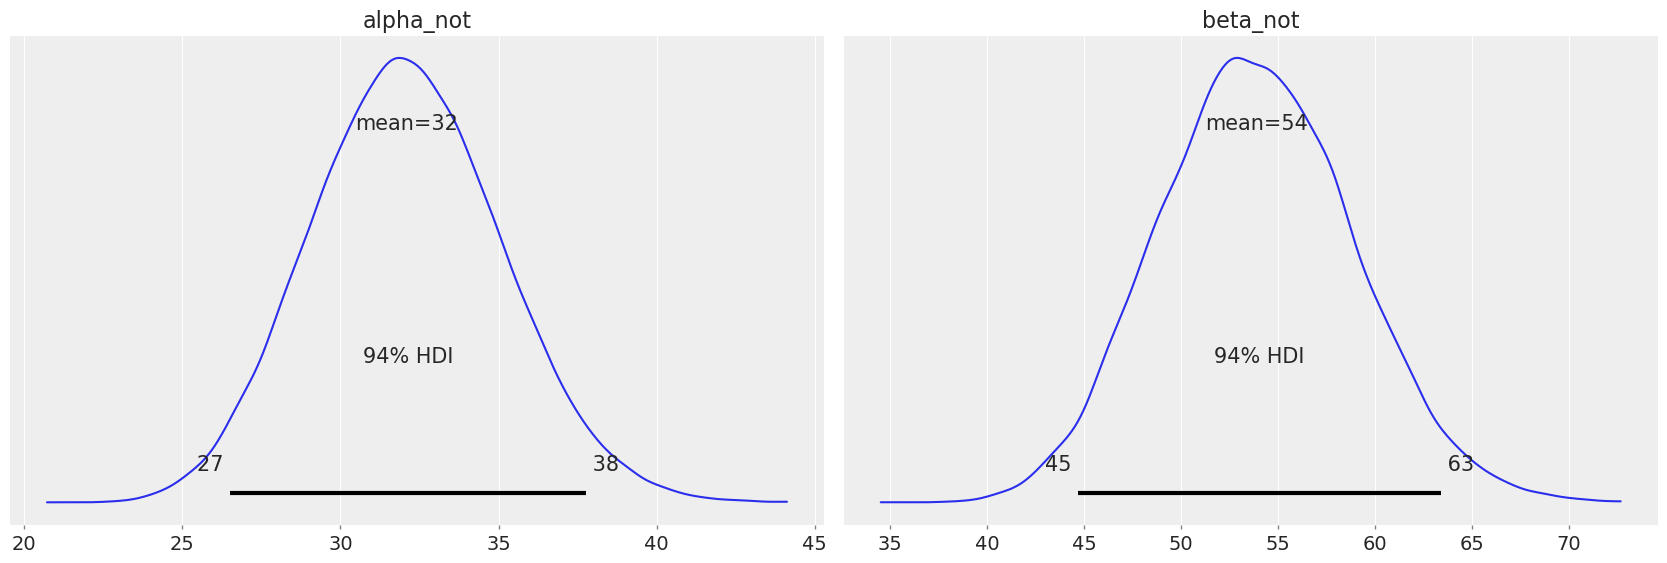

In [36]:
az.summary(trace3, var_names=["alpha_hot", "beta_hot", "alpha_not", "beta_not"])
az.plot_posterior(trace3, var_names=["alpha_hot", "beta_hot"])
az.plot_posterior(trace3, var_names=["alpha_not", "beta_not"])

<div style="color:blue">

### Model 3 Commentary 
* Even when relaxing the hot-streak definition to include more data, the model still finds increased variation (and similar average success) in hot vs. not-hot shooting — suggesting the perceived hot hand may be more about variability than a consistent skill boost.